<a href="https://colab.research.google.com/github/AlexHudnev/mla/blob/main/MLA_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import floor, log
from itertools import zip_longest

def tiles (size, numtilings, floats, ints=[]):
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hash(tuple(coords)) % size)
    return Tiles

In [ ]:
import random
import math
class MountainCar():
  def __init__(self):
      self.reset()
  def reset(self):
      self.position = -0.6 + random.random()*0.2
      self.velocity = 0.0
      return [self.position,self.velocity]

  def step(self,A):
      if not A in (0,1,2):
          print('Invalid action:', A)
          raise StandardError
      A = A - 1
      self.velocity += 0.001*A - 0.0025*math.cos(3*self.position)
      self.velocity = min(max(self.velocity, -0.07), 0.07)
      self.position += self.velocity
      if self.position >= 0.5:
          return [self.position,self.velocity], 0
      if self.position <= -1.2:
          self.position = -1.2
          self.velocity = 0.0
      return [self.position,self.velocity] , -1

In [ ]:
import numpy as np


def get_feature_vector(position, velocity, action):
    indices = tiles(32768, 10, [9*position/(1.7), 9*velocity/(0.14)], action)
    feature_vector = np.zeros((32768,))
    feature_vector[indices] = 1
    return feature_vector

class Agent(object):
    def __init__(self, 
                 param_vector_size, 
                 learning_rate, 
                 epsilon,
                 discount):
        self.weights = np.zeros((param_vector_size,))
        self.action_space = [0, 1, 2]
        self.learning_rate = learning_rate
        self.discount = discount
        self.feature_vector = get_feature_vector(0.0, 0.0, [0])
        self.action = [1]
        self.epsilon = epsilon
        
    def step(self, reward, new_state, done):
        if done:
            self.update_weights(reward, done)
        else:
            new_action = self.epsilon_greedy(new_state)
            new_feature_vector = get_feature_vector(new_state[0], 
                                                    new_state[1], 
                                                    new_action)
            self.update_weights(reward, done, new_feature_vector)
            self.feature_vector = new_feature_vector
            self.action = new_action
        return self.action
        
    def epsilon_greedy(self, new_state):
        import random
        
        random_float = random.uniform(0,1.0)
        if random_float > (1 - self.epsilon):
            action = [random.choice([0,1,2])]
        else:
            values = []
            for action_candidate in self.action_space:
                new_feature_vector = get_feature_vector(new_state[0], 
                                                        new_state[1], 
                                                        [action_candidate])
                values.append(self.compute_value(new_feature_vector))

            action = [values.index(max(values))]
        return action
        
    def compute_value(self, feature_vector):
        return np.dot(self.weights, feature_vector)
    
    def update_weights(self, 
                       reward, 
                       terminal, 
                       feature_vector_tp1=np.zeros((32768,))):
        if terminal:
            error = reward - self.compute_value(self.feature_vector)
        else:
            error = reward + self.discount * self.compute_value(feature_vector_tp1)- self.compute_value(self.feature_vector)
        self.weights += self.learning_rate * error * self.feature_vector



In [ ]:
from tqdm import tqdm_notebook
def train(agent, num_episodes=9000):
    env = MountainCar()
    episode_rewards = []
    count_for_done = []
    action = [random.choice([0,1,2])]
    
    for episode in tqdm_notebook(range(num_episodes), 'Episodes'):
        ob = env.reset()
        episode_rewards_sum = 0
        done = False
        count = 0
    
        while not done:
            count += 1

            new_ob, reward = env.step(action[0])

            if reward == 0: done = True
            episode_rewards_sum += reward
            action = agent.step(reward, new_ob, done)
        
        episode_rewards.append(episode_rewards_sum)
        count_for_done.append(count)
        
    return episode_rewards, agent, count_for_done

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Text(0.5, 0, 'Episodes')

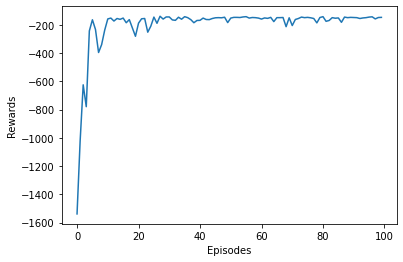

In [ ]:
agent = Agent(param_vector_size=32768,
              learning_rate=0.05,
              discount=0.9,
              epsilon=0.0)
episode_rewards, agent, count_for_done = train(agent, num_episodes=100)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(episode_rewards)
plt.ylabel("Rewards")
plt.xlabel("Episodes")

147


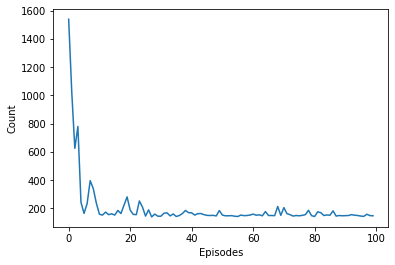

In [ ]:
plt.plot(count_for_done)
plt.ylabel("Count")
plt.xlabel("Episodes")
print(count_for_done[-1])